# GAN으로 새로운 패션아이템 생성하기
*GAN을 이용하여 새로운 패션 아이템을 만들어봅니다*

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

EPOCHS 과 BATCH_SIZE 등 학습에 필요한 하이퍼 파라미터 들을 설정해 줍니다.

In [2]:
# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 장치를 사용합니다:", DEVICE)

다음 장치를 사용합니다: cpu


학습에 필요한 데이터셋을 로딩합니다. 

In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ]),
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
)


생성자는 64차원의 랜덤한 텐서를 입력받아 이에 행렬곱(Linear)과 활성화 함수(ReLU, Tanh) 연산을 실행합니다. 생성자의 결과값은 784차원, 즉 Fashion MNIST 속의 이미지와 같은 차원의 텐서입니다.

In [4]:
# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())

판별자는 784차원의 텐서를 입력받습니다. 판별자 역시 입력된 데이터에 행렬곱과 활성화 함수를 실행시키지만, 생성자와 달리 판별자의 결과값은 입력받은 텐서가 진짜인지 구분하는 예측값입니다.

In [5]:
# 판별자 (Discriminator)
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

생성자와 판별자 학습에 쓰일 오차 함수와 최적화 알고리즘도 정의해 줍니다.

In [6]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

모델 학습에 필요한 준비는 끝났습니다. 그럼 본격적으로 GAN을 학습시키는 loop을 만들어 보겠습니다. 

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 계산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 생성자와 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차를 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

이폭 [0/500], d_loss: 0.0517, g_loss: 5.3337, D(x): 0.98, D(G(z)): 0.01
이폭 [1/500], d_loss: 0.0423, g_loss: 4.7774, D(x): 0.98, D(G(z)): 0.01
이폭 [2/500], d_loss: 0.0235, g_loss: 9.5618, D(x): 0.99, D(G(z)): 0.00
이폭 [3/500], d_loss: 0.0824, g_loss: 11.0896, D(x): 0.99, D(G(z)): 0.01
이폭 [4/500], d_loss: 0.0949, g_loss: 6.7157, D(x): 0.96, D(G(z)): 0.00
이폭 [5/500], d_loss: 0.1762, g_loss: 8.7583, D(x): 0.95, D(G(z)): 0.00
이폭 [6/500], d_loss: 0.1732, g_loss: 7.4020, D(x): 0.96, D(G(z)): 0.01
이폭 [7/500], d_loss: 0.1788, g_loss: 4.9927, D(x): 0.94, D(G(z)): 0.04
이폭 [8/500], d_loss: 0.1049, g_loss: 6.5116, D(x): 0.95, D(G(z)): 0.01
이폭 [9/500], d_loss: 0.1675, g_loss: 4.9593, D(x): 0.97, D(G(z)): 0.09
이폭 [10/500], d_loss: 0.3250, g_loss: 3.5911, D(x): 0.90, D(G(z)): 0.06
이폭 [11/500], d_loss: 0.2156, g_loss: 3.6541, D(x): 0.94, D(G(z)): 0.08
이폭 [12/500], d_loss: 0.1852, g_loss: 4.4912, D(x): 0.94, D(G(z)): 0.04
이폭 [13/500], d_loss: 0.4532, g_loss: 5.0478, D(x): 0.89, D(G(z)): 0.04
이폭 [14/500], d_

이폭 [116/500], d_loss: 0.7119, g_loss: 1.9846, D(x): 0.78, D(G(z)): 0.27
이폭 [117/500], d_loss: 0.8703, g_loss: 1.6425, D(x): 0.69, D(G(z)): 0.31
이폭 [118/500], d_loss: 1.1388, g_loss: 1.2210, D(x): 0.65, D(G(z)): 0.37
이폭 [119/500], d_loss: 0.8922, g_loss: 1.6644, D(x): 0.69, D(G(z)): 0.29
이폭 [120/500], d_loss: 0.8903, g_loss: 1.5726, D(x): 0.70, D(G(z)): 0.29
이폭 [121/500], d_loss: 1.0577, g_loss: 1.7370, D(x): 0.67, D(G(z)): 0.32
이폭 [122/500], d_loss: 0.7625, g_loss: 1.6517, D(x): 0.75, D(G(z)): 0.29
이폭 [123/500], d_loss: 0.9586, g_loss: 1.6643, D(x): 0.68, D(G(z)): 0.32
이폭 [124/500], d_loss: 0.8930, g_loss: 1.7719, D(x): 0.66, D(G(z)): 0.24
이폭 [125/500], d_loss: 1.0863, g_loss: 1.2074, D(x): 0.68, D(G(z)): 0.38
이폭 [126/500], d_loss: 1.0721, g_loss: 1.5532, D(x): 0.64, D(G(z)): 0.31
이폭 [127/500], d_loss: 1.1942, g_loss: 1.3606, D(x): 0.63, D(G(z)): 0.35
이폭 [128/500], d_loss: 0.9575, g_loss: 1.4784, D(x): 0.73, D(G(z)): 0.36
이폭 [129/500], d_loss: 1.1354, g_loss: 1.3422, D(x): 0.69, D(G(z)

이폭 [230/500], d_loss: 1.3774, g_loss: 1.0186, D(x): 0.57, D(G(z)): 0.45
이폭 [231/500], d_loss: 0.8511, g_loss: 1.7248, D(x): 0.75, D(G(z)): 0.34
이폭 [232/500], d_loss: 0.8969, g_loss: 1.3546, D(x): 0.71, D(G(z)): 0.36
이폭 [233/500], d_loss: 1.2999, g_loss: 1.2289, D(x): 0.55, D(G(z)): 0.37
이폭 [234/500], d_loss: 1.3391, g_loss: 1.0364, D(x): 0.61, D(G(z)): 0.46
이폭 [235/500], d_loss: 1.2065, g_loss: 1.3167, D(x): 0.57, D(G(z)): 0.33
이폭 [236/500], d_loss: 0.9483, g_loss: 1.3871, D(x): 0.68, D(G(z)): 0.35
이폭 [237/500], d_loss: 1.0451, g_loss: 1.2171, D(x): 0.62, D(G(z)): 0.36
이폭 [238/500], d_loss: 1.0435, g_loss: 1.2751, D(x): 0.62, D(G(z)): 0.35
이폭 [239/500], d_loss: 1.0476, g_loss: 1.4329, D(x): 0.59, D(G(z)): 0.31
이폭 [240/500], d_loss: 1.0624, g_loss: 1.1191, D(x): 0.64, D(G(z)): 0.36
이폭 [241/500], d_loss: 1.2682, g_loss: 1.1876, D(x): 0.54, D(G(z)): 0.37
이폭 [242/500], d_loss: 1.1038, g_loss: 1.6794, D(x): 0.62, D(G(z)): 0.32
이폭 [243/500], d_loss: 0.7904, g_loss: 1.5797, D(x): 0.68, D(G(z)

이폭 [344/500], d_loss: 1.0822, g_loss: 1.1705, D(x): 0.62, D(G(z)): 0.36
이폭 [345/500], d_loss: 1.0958, g_loss: 1.3426, D(x): 0.62, D(G(z)): 0.35
이폭 [346/500], d_loss: 1.0344, g_loss: 1.2195, D(x): 0.67, D(G(z)): 0.39
이폭 [347/500], d_loss: 1.0586, g_loss: 1.1899, D(x): 0.67, D(G(z)): 0.38
이폭 [348/500], d_loss: 1.2396, g_loss: 1.2719, D(x): 0.53, D(G(z)): 0.35
이폭 [349/500], d_loss: 1.0794, g_loss: 1.3407, D(x): 0.62, D(G(z)): 0.33
이폭 [350/500], d_loss: 0.9795, g_loss: 1.3808, D(x): 0.62, D(G(z)): 0.30
이폭 [351/500], d_loss: 1.0403, g_loss: 1.4747, D(x): 0.60, D(G(z)): 0.29
이폭 [352/500], d_loss: 0.8785, g_loss: 1.4137, D(x): 0.67, D(G(z)): 0.31
이폭 [353/500], d_loss: 0.8473, g_loss: 1.4848, D(x): 0.70, D(G(z)): 0.30
이폭 [354/500], d_loss: 1.0922, g_loss: 1.5542, D(x): 0.61, D(G(z)): 0.32
이폭 [355/500], d_loss: 1.2177, g_loss: 1.2611, D(x): 0.64, D(G(z)): 0.40
이폭 [356/500], d_loss: 0.9436, g_loss: 1.3057, D(x): 0.67, D(G(z)): 0.34
이폭 [357/500], d_loss: 1.0562, g_loss: 1.3107, D(x): 0.62, D(G(z)

이폭 [458/500], d_loss: 0.8459, g_loss: 1.5498, D(x): 0.74, D(G(z)): 0.32
이폭 [459/500], d_loss: 1.3327, g_loss: 1.2529, D(x): 0.54, D(G(z)): 0.35
이폭 [460/500], d_loss: 1.4171, g_loss: 1.2155, D(x): 0.54, D(G(z)): 0.37
이폭 [461/500], d_loss: 1.0387, g_loss: 1.4000, D(x): 0.68, D(G(z)): 0.36
이폭 [462/500], d_loss: 0.6517, g_loss: 1.9844, D(x): 0.73, D(G(z)): 0.22
이폭 [463/500], d_loss: 1.2101, g_loss: 1.3964, D(x): 0.60, D(G(z)): 0.35
이폭 [464/500], d_loss: 1.1602, g_loss: 1.3941, D(x): 0.60, D(G(z)): 0.35
이폭 [465/500], d_loss: 0.9925, g_loss: 1.4357, D(x): 0.67, D(G(z)): 0.33
이폭 [466/500], d_loss: 0.9386, g_loss: 1.3091, D(x): 0.71, D(G(z)): 0.33
이폭 [467/500], d_loss: 1.0256, g_loss: 1.3829, D(x): 0.62, D(G(z)): 0.32
이폭 [468/500], d_loss: 1.5848, g_loss: 0.8309, D(x): 0.60, D(G(z)): 0.51
이폭 [469/500], d_loss: 0.9377, g_loss: 1.3113, D(x): 0.69, D(G(z)): 0.34
이폭 [470/500], d_loss: 0.7511, g_loss: 1.5858, D(x): 0.75, D(G(z)): 0.28
이폭 [471/500], d_loss: 1.3555, g_loss: 1.2259, D(x): 0.61, D(G(z)

학습이 끝난 생성자의 결과물을 한번 확인해 보겠습니다.

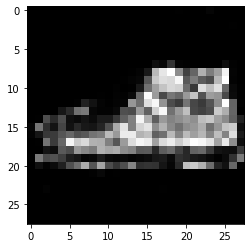

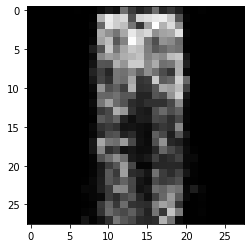

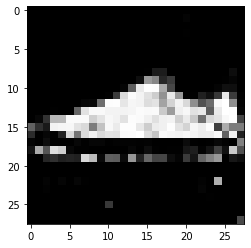

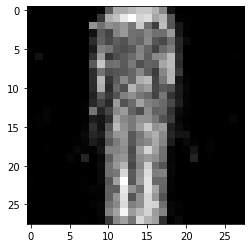

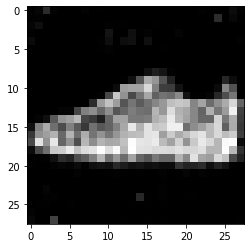

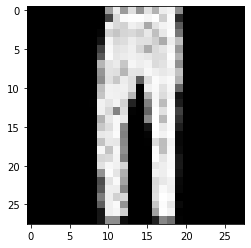

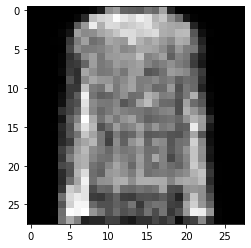

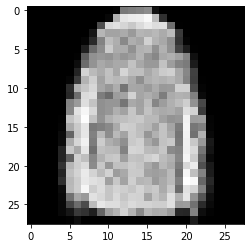

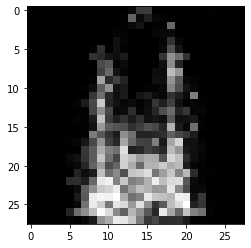

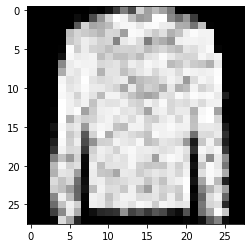

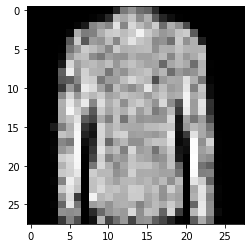

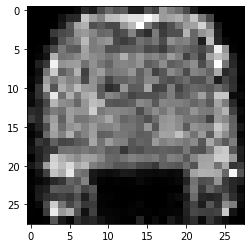

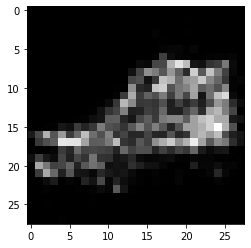

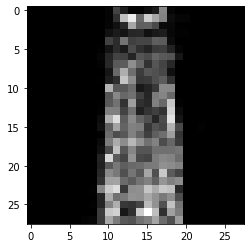

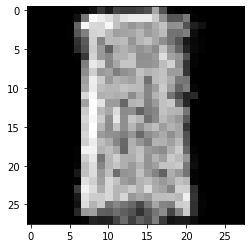

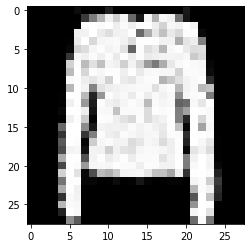

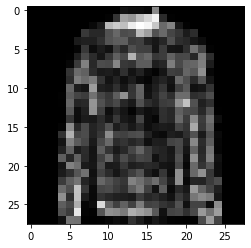

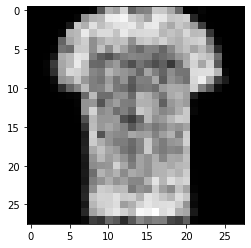

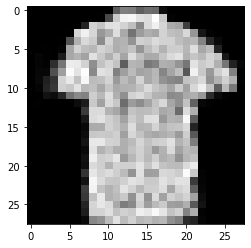

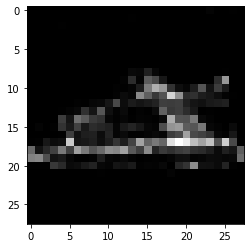

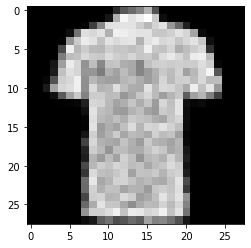

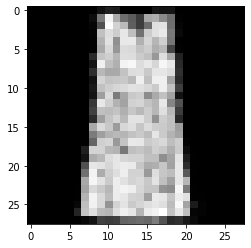

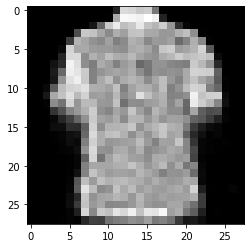

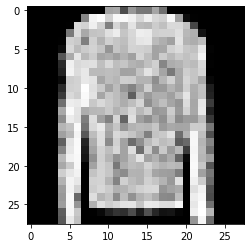

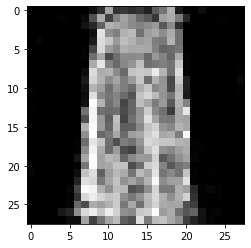

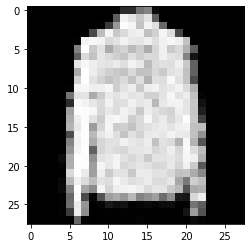

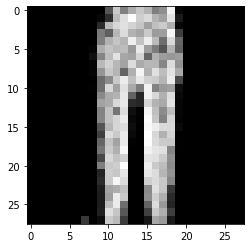

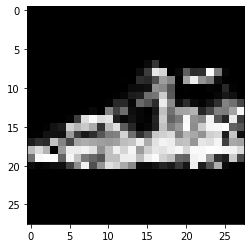

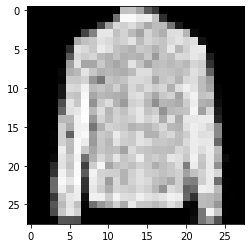

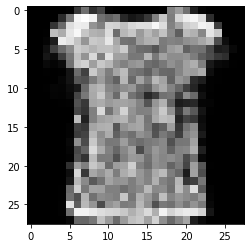

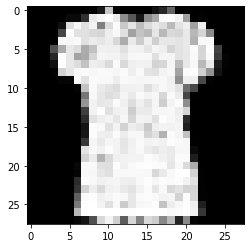

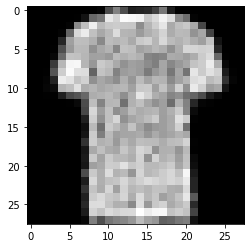

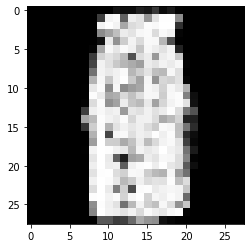

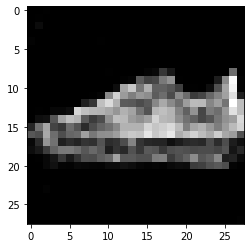

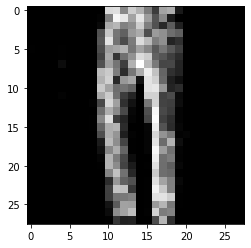

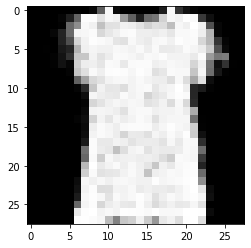

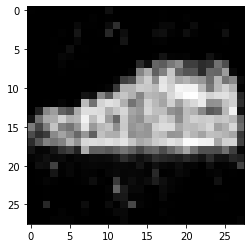

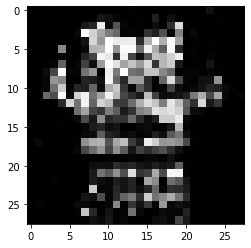

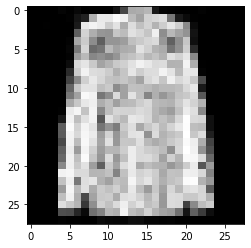

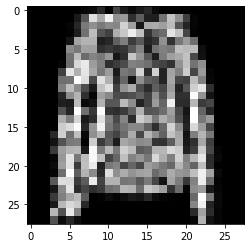

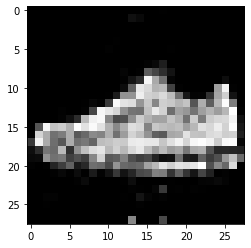

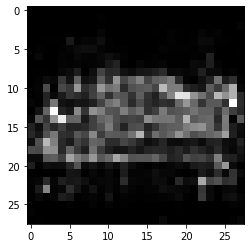

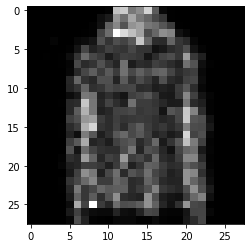

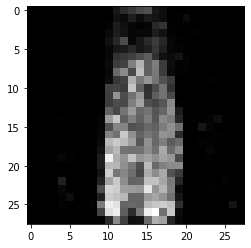

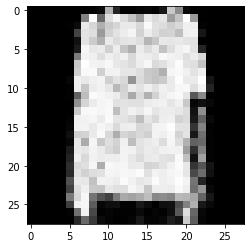

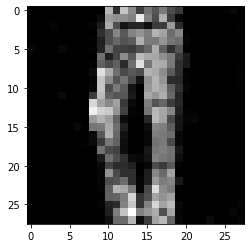

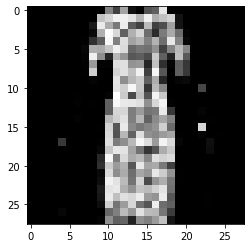

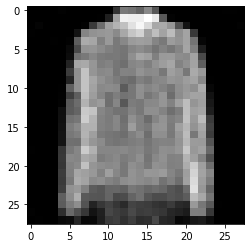

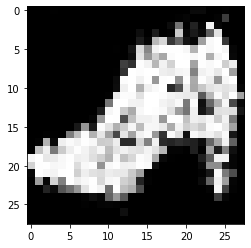

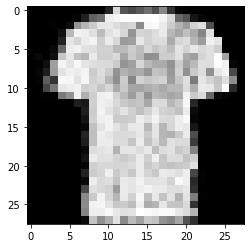

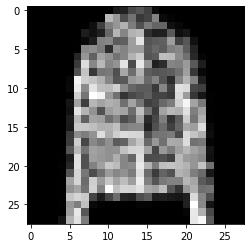

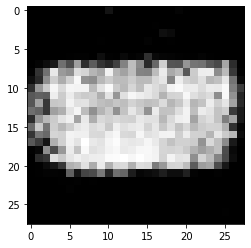

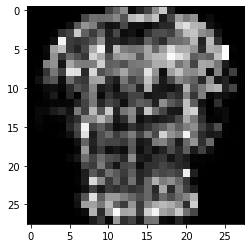

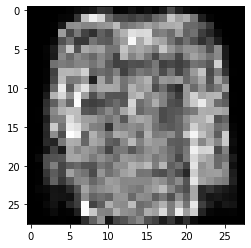

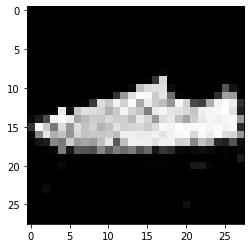

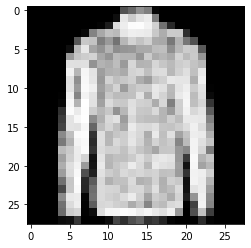

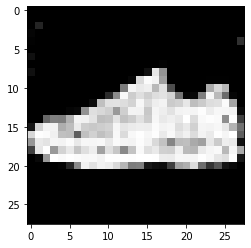

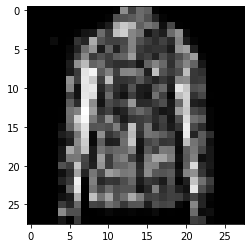

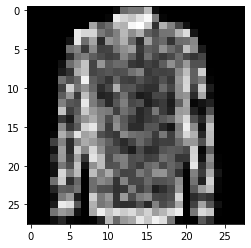

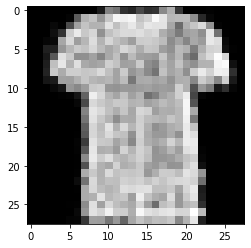

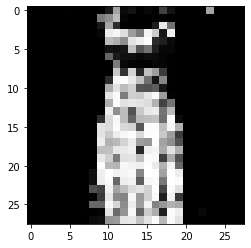

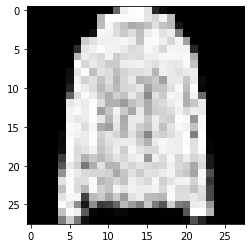

In [8]:
# 생성자가 만든 이미지 시각화하기
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(64):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()

이 프로젝트는 최윤제님의 파이토치 튜토리얼 사용 허락을 받아 참고했습니다.

* [yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial) - MIT License